In [1]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,classification

from yellowbrick.text import FreqDistVisualizer
from nltk.corpus import stopwords
import requests
import time
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import re

In [7]:
def get_reddit_posts(subreddit, pages):
    url = "https://www.reddit.com/r/" + subreddit + ".json"
    headers = {'User-agent':'Time Bandit'}
    after = None
    posts = []
    for j in range(pages):
        if after==None:
            params = {}
        else:
            params = {'after':after}
#         print(j)  # just to keep track of progress while it is running
        res = requests.get(url,params=params, headers=headers)
        if res.status_code==200:
            the_json = res.json()
            for i in range(len(the_json['data']['children'])):
                posts.append({'subreddit': the_json['data']['children'][i]['data']['subreddit'],
                                  'name':the_json['data']['children'][i]['data']['name'],
                                  'title':the_json['data']['children'][i]['data']['title'],
                              'text':the_json['data']['children'][i]['data']['selftext'],
                              'url':the_json['data']['children'][i]['data']['url'],
                                 'is_self': the_json['data']['children'][i]['data']['is_self']})
            after = the_json['data']['after']
        else:
            print(res.status_code)
            break
        time.sleep(1)
    df = pd.DataFrame(posts)
    return df

In [10]:
df = get_reddit_posts('askwomen',40)

In [11]:
df.to_pickle('askwomen.pkl')

In [12]:
df = get_reddit_posts('askmen',40)

In [13]:
df.to_pickle('askmen.pkl')

In [14]:
df_askwomen = pd.read_pickle('./askwomen.pkl')

In [15]:
df = pd.concat([df, df_askwomen])
df = df.reset_index(drop=True)
df.subreddit.value_counts()

AskMen      997
AskWomen    985
Name: subreddit, dtype: int64

In [16]:
df['is_self'].value_counts()

True    1982
Name: is_self, dtype: int64

In [133]:
df.drop_duplicates(inplace=True)

In [157]:
df.subreddit.value_counts(normalize=True)

AskWomen    0.599831
AskMen      0.400169
Name: subreddit, dtype: float64

In [7]:
# remove cases with blank text
# df = df[df['text']!='']

In [17]:
# combine title and selftext into one text column
df['text'] = df['text'] +' '+ df['title']

In [18]:
# Data Cleaning
# Binarize label column
df['askmen'] = df['subreddit'].apply(lambda x: 1 if x == 'AskMen' else 0)

# get rid of \n,  and &amp in text
df['text'] = df['text'].map(lambda x: x.replace('\n',' '))

df['text'] = df['text'].map(lambda x: x.replace('&amp;','and'))

In [19]:
# Load stopwords from NLTK and add custom words
mystopwords = stopwords.words('english')
mystopwords.extend(['like','would','get','x200b','https','one','www','com','org','etc','could'])

In [134]:
X = df['text']  # X will be turned into a matrix
y = df['askmen']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [137]:
# Logistic Regression model with Count Vectorizer
cvec = CountVectorizer(stop_words=mystopwords,max_features=None, ngram_range=(1,1))

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

lr = LogisticRegression(penalty='l2',solver='liblinear',C=1)

lr.fit(X_train_cvec, y_train)

print('Logistic Regression model with Count Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_cvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_cvec, y_test):.3f}')

Logistic Regression model with Count Vectorizer
Train score: 0.964
Test score: 0.709


In [138]:
# set up X, y for Naive Bayes and SVC Models
X = df[['text']]  # X is a pd Dataframe
y = df['askmen']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [143]:
cvec = CountVectorizer(stop_words=mystopwords,max_features=None,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.05)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Bernoulli model with Count Vectorizer
Train data accuracy: 0.871
Test data accuracy: 0.679


In [151]:
cvec = CountVectorizer(stop_words=None,max_features=None,max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=1)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Multinomial model with Count Vectorizer
Train data accuracy: 0.894
Test data accuracy: 0.706


In [158]:
tvec = TfidfVectorizer(stop_words=None,max_features=4000, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=.3)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Multinomial model with TF-IDF Vectorizer
Train data accuracy: 0.950
Test data accuracy: 0.713


In [165]:
tvec = TfidfVectorizer(stop_words=mystopwords,max_features=5000,
                       max_df=1.0,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=1)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Bernoulli model with TF-IDF Vectorizer
Train data accuracy: 0.757
Test data accuracy: 0.682


In [194]:
# SVM model
cvec = CountVectorizer(stop_words=mystopwords,max_features=100, ngram_range=(1,1))
        # limiting features does not reduce performance and speeds calculation 
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())
# Instantiate SVM.
# svc = svm.SVC(kernel='sigmoid', C = 1.8, gamma = .05) 
svc = svm.SVC(kernel='rbf', C = 1.5, gamma = .05)  

# Fit on training data.
svc.fit(X_train_cvec,y_train)

# Score model on the training set.
print('Support Vector Machine model with Count Vectorizer')
print(f'Train data accuracy: {svc.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {svc.score(X_test_cvec,y_test):.3f}')

Support Vector Machine model with Count Vectorizer
Train data accuracy: 0.793
Test data accuracy: 0.736


In [195]:
# print confusion matrix with best model
y_pred = svc.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['predict neg', 'predict pos'], index=['actual neg', 'actual pos'])
cm_df

,predict neg,predict pos
actual neg,166,12
actual pos,66,52


In [196]:
# add predicted and actual y to test dataset
X_test['y_test'] = pd.Series(y_test, index=X_test.index)
X_test['y_pred'] = pd.Series(y_pred, index=X_test.index)

import re
# count words in text
X_test['word_count'] = pd.Series([len(re.findall(r'\w+', x)) for x in X_test.text], index=X_test.index)

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [197]:
# list false positives - predicted Men but actually Women
mask = (X_test['y_test']==0) & (X_test['y_pred'] ==1)
X_test[mask]

,text,y_test,y_pred,word_count
1216,"How do you guys live with, get around, etc kno...",0,1,111
1612,What's your opinion of/experience with men wh...,0,1,15
1001,"Dear women of Reddit, what is something you w...",0,1,14
1249,If you have been with your partner for a while...,0,1,72
1682,"Whether you talk of face creams, body creams, ...",0,1,73
1383,"Women who are competitive gamers, does it oft...",0,1,24
1424,"Ladies, what is your experience with men who ...",0,1,14
1270,Interested in hearing your experiences of bein...,0,1,177
1471,I’ve never had coffee. 🤷🏼‍♀️ What’s the most o...,0,1,15
1369,I ask because some people get the idea that we...,0,1,30


In [199]:
X_test.text.loc[1095]

' What is the most prevalent example of casual sexism/misogyny within an average conversation between guys?'

In [200]:
# list false negatives -- predicted Women but Men
mask = (X_test['y_test']==1) & (X_test['y_pred'] ==0)
X_test[mask]

,text,y_test,y_pred,word_count
285,What’s the most awkward moment you have nutted?,1,0,9
302,"In the early stages of dating someone, what a...",1,0,26
388,Now it's time to shit all over your favorite m...,1,0,31
248,What were some struggles you and your SO face...,1,0,19
406,What crap did you tolerate from an ex till yo...,1,0,14
386,What are some inconsistencies or plot holes f...,1,0,23
94,What one positive thing would all your exes a...,1,0,15
416,What's ths worst April fools joke you've ever ...,1,0,23
340,To show off any gains- I know this sounds comp...,1,0,31
334,What industry should we just let die?,1,0,7


In [130]:
X_test.text.loc[682]

'The only time people seem to invite me to do stuff is weekends, but it’s starting to feel like I’m just a friend used to increase pack numbers when going out. What can someone do to make themselves more appealing to be around outside of partying? How to make yourself a “weekday friend”'

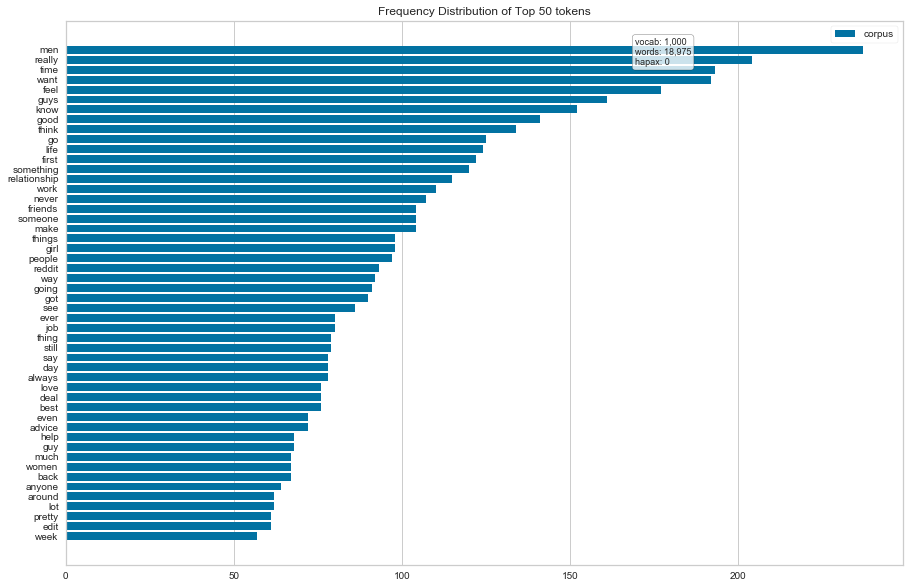

In [107]:
# https://www.scikit-yb.org/en/latest/api/text/freqdist.html
cvec = CountVectorizer(stop_words=mystopwords,max_features=1000, ngram_range=(1,1))
mask       = (df['askmen'] == 1)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50)
visualizer.fit(docs)
visualizer.poof()

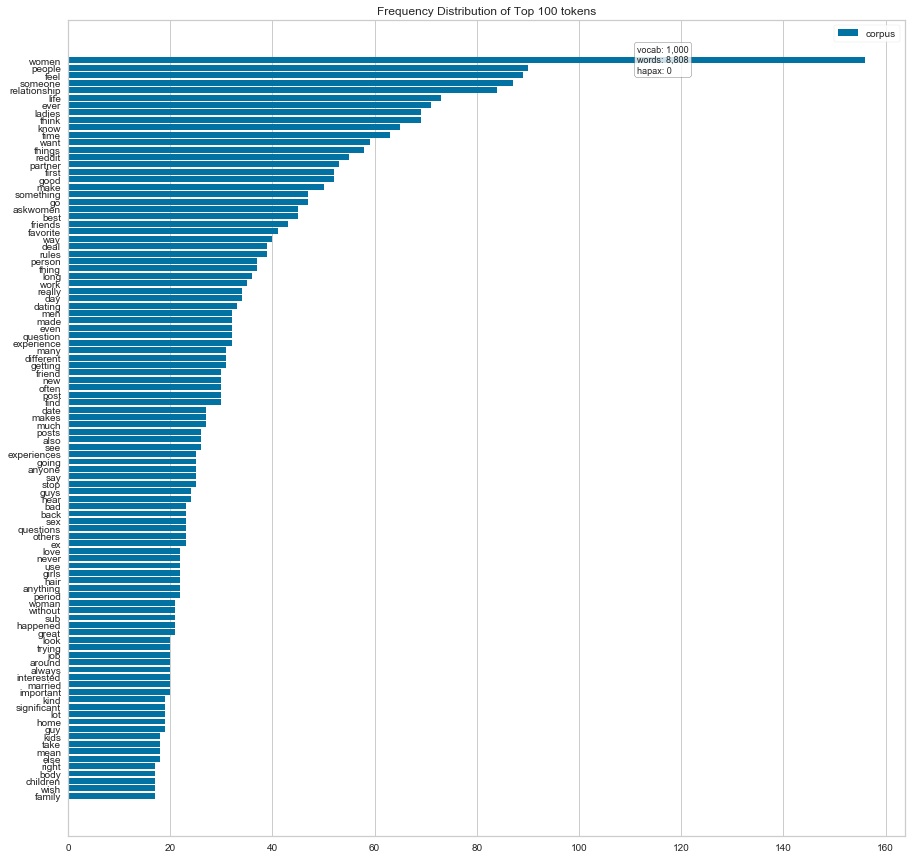

In [110]:
mask       = (df['askmen'] == 0)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,15))
visualizer = FreqDistVisualizer(features=features,n=100)
visualizer.fit(docs)
visualizer.poof()

In [111]:
def make_wc(mask):
    # use visualizer to create word frequency list for Wordcloud
    # (it is also possible to let wordcloud create the list)
    docs       = cvec.fit_transform(text for text in df['text'][mask])
    features   = cvec.get_feature_names()
    #create dataframe of word frequencies
    word_freq = pd.DataFrame({'word':features,'freq':list(visualizer.count(docs))})
    word_freq = word_freq.sort_values(by = ['freq'],ascending=False)
    # convert df into dict
    w_dict = dict([(word_freq['word'].iloc[i],word_freq['freq'].iloc[i]) for i in range(len(word_freq))])
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=1000,height=500,scale=1,background_color="white").generate_from_frequencies(w_dict)
    # Display the generated image:
    plt.rcParams['figure.figsize'] = (20, 10)
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis("off")
    plt.show()
    return fig

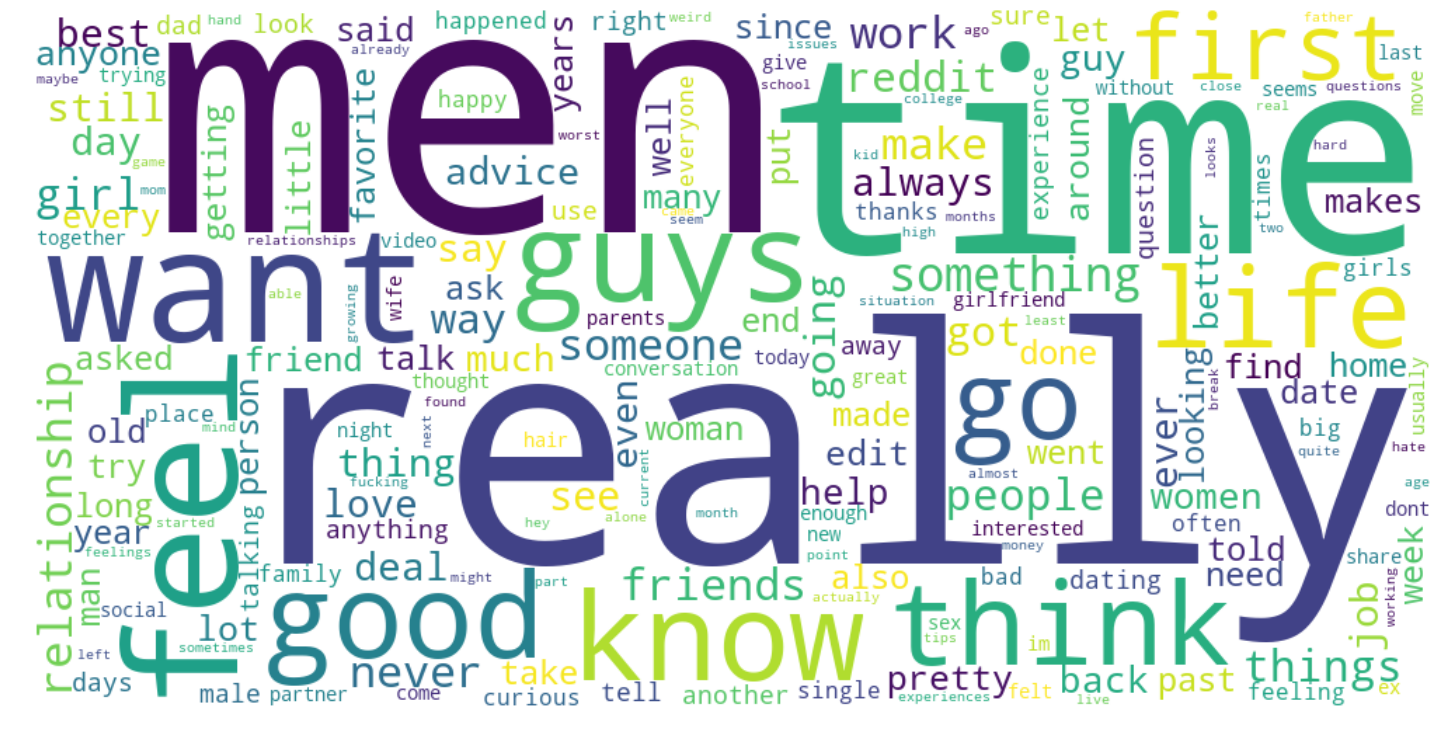

In [112]:
mask = (df['askmen'] == 1)  # select which subreddit to use
name = 'askmen'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');

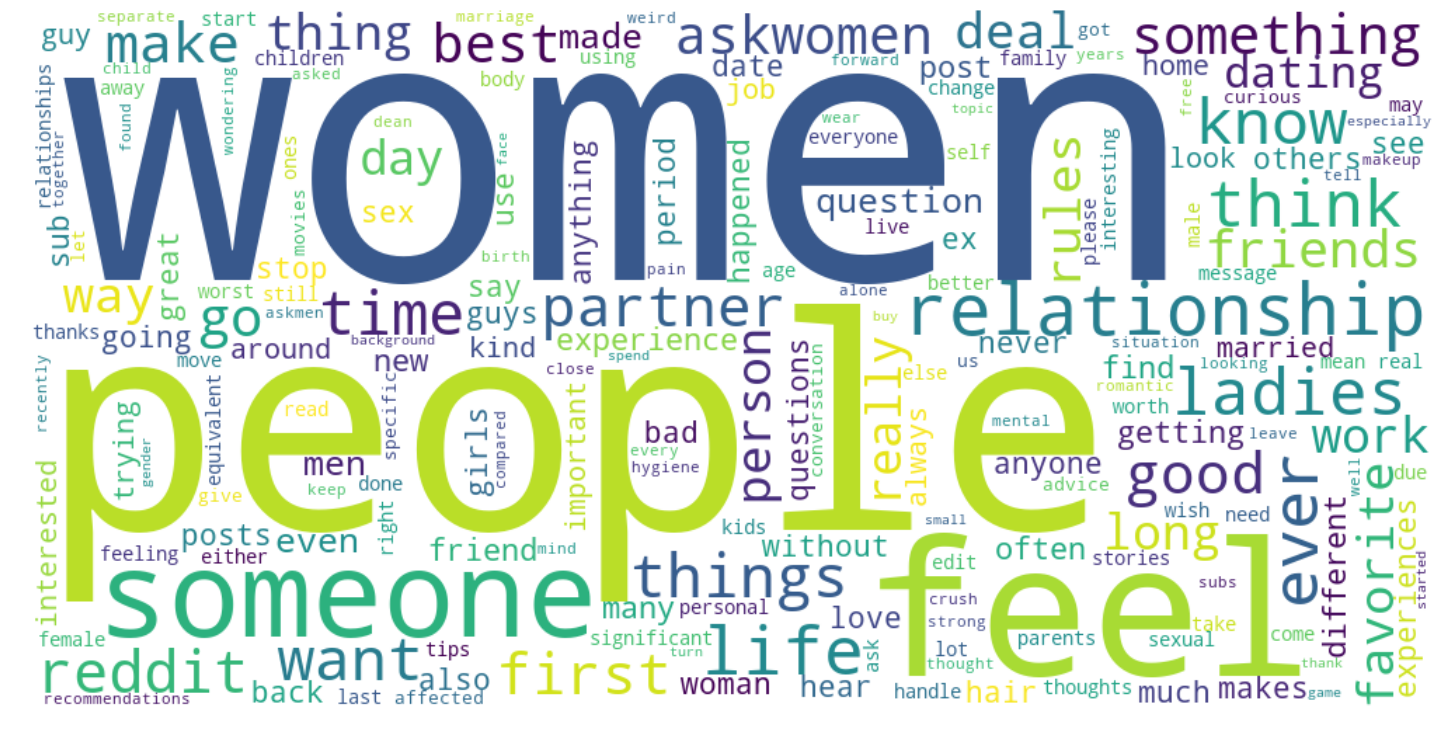

In [113]:
mask = (df['askmen'] == 0)  # select which subreddit to use
name = 'askwomen'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');